# Data Analytics I: Assignment 2


Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from memory_profiler import memory_usage

Extracting data from csv


In [2]:
def extract_data(file):
    data = pd.read_csv(file)
    return data


data = extract_data("Electric_Vehicle_Data.csv")

In [3]:
data.columns

Index(['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'Legislative District', 'DOL Vehicle ID',
       'Vehicle Location', 'Electric Utility', '2020 Census Tract'],
      dtype='object')

Using only the relevant columns


In [4]:
data_reduced = data[
    [
        "Make",
        "Model",
        "Electric Vehicle Type",
        "Electric Range",
        "Base MSRP",
        "Model Year",
        "State",
        "Clean Alternative Fuel Vehicle (CAFV) Eligibility",
    ]
]

In [5]:
data_reduced["Electric Range"].value_counts()
data_reduced["Base MSRP"].value_counts()

0         178146
69900       1346
31950        382
52900        221
32250        134
59900        130
54950        129
39995        111
36900        104
44100         94
45600         82
64950         82
33950         74
34995         66
52650         65
36800         54
55700         51
53400         38
81100         22
98950         20
110950        20
90700         19
75095         14
102000        11
184400        10
43700          9
89100          8
109000         7
91250          5
32995          3
845000         1
Name: Base MSRP, dtype: int64

Filling up zero values in `Electric Range` and `Base MSRP` columns:

- Each zero has been replaced with the mean of non-zero values from rows with the same `Make` and `Model`.

- If there are no non-zero values for the specific `Make` and `Model`, the zero has been replaced with the median of non-zero values for the same `Make`.

- If neither group exists, it has been replaced with the overall median of non-zero values in the entire column.

All replacement values are rounded to the nearest integer to maintain consistency in the data.


In [6]:
def replace_zeros_with_mean(df, group_columns, target_column):
    overall_median = df[df[target_column] != 0][target_column].median()

    mean_make_model = (
        df[df[target_column] != 0]
        .groupby(group_columns)[target_column]
        .mean()
        .reset_index()
    )

    median_make = (
        df[df[target_column] != 0]
        .groupby(group_columns[0])[target_column]
        .median()
        .reset_index()
    )

    df = df.merge(
        mean_make_model, on=group_columns, how="left", suffixes=("", "_mean_make_model")
    )
    df = df.merge(
        median_make, on=group_columns[0], how="left", suffixes=("", "_median_make")
    )

    df[target_column] = df.apply(
        lambda row: (
            round(row[f"{target_column}_mean_make_model"])
            if row[target_column] == 0
            and not pd.isna(row[f"{target_column}_mean_make_model"])
            else (
                round(row[f"{target_column}_median_make"])
                if row[target_column] == 0
                and not pd.isna(row[f"{target_column}_median_make"])
                else (
                    round(overall_median)
                    if row[target_column] == 0
                    else round(row[target_column])
                )
            )
        ),
        axis=1,
    )

    df = df.drop(
        columns=[f"{target_column}_mean_make_model", f"{target_column}_median_make"]
    )

    return df

In [7]:
data_reduced = replace_zeros_with_mean(
    data_reduced, ["Make", "Model"], "Electric Range"
)
data_reduced = replace_zeros_with_mean(data_reduced, ["Make", "Model"], "Base MSRP")


data_reduced["Electric Range"].value_counts()
data_reduced["Base MSRP"].value_counts()

59900     74630
69900     74387
31950      7431
53025      6782
69019      6255
39995      3059
52900      2808
64950      1480
81100      1025
34995       838
36900       809
75095       434
44745       275
32250       134
184400      132
54950       129
54349       123
102000      112
44100        94
45600        82
33950        74
52650        65
36866        62
36800        54
55700        51
53400        38
110950       20
98950        20
90700        19
43700         9
89100         8
109000        7
91250         5
32855         3
32995         3
845000        1
Name: Base MSRP, dtype: int64

In [8]:
data_reduced.head()

,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Model Year,State,Clean Alternative Fuel Vehicle (CAFV) Eligibility
0,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),16,59900,2017,WA,Not eligible due to low battery range
1,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),16,59900,2018,WA,Not eligible due to low battery range
2,TESLA,MODEL S,Battery Electric Vehicle (BEV),210,69019,2017,WA,Clean Alternative Fuel Vehicle Eligible
3,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),25,59900,2021,WA,Not eligible due to low battery range
4,TESLA,MODEL 3,Battery Electric Vehicle (BEV),308,69900,2020,WA,Clean Alternative Fuel Vehicle Eligible


## Attribute-Oriented Induction

Concept Hierarchy


In [9]:
def create_concept_hierarchy(data):
    concept_hierarchy = {}

    makes = data["Make"].unique()
    concept_hierarchy["Make"] = {make: make for make in makes}

    concept_hierarchy["Electric Vehicle Type"] = {
        "Battery Electric Vehicle (BEV)": "FullElectric",
        "Plug-in Hybrid Electric Vehicle (PHEV)": "HybridElectric",
    }

    concept_hierarchy["Electric Range"] = lambda x: (
        "LongRange" if x > 200 else ("MediumRange" if x > 100 else "ShortRange")
    )

    concept_hierarchy["Base MSRP"] = lambda x: (
        "HighEnd" if x > 50000 else ("MidRange" if x > 30000 else "Affordable")
    )

    concept_hierarchy["Model Year"] = (
        lambda x: str(x // 10 * 10) + "s"
    )  # Generalize to decades

    regions = {
        "West": ["WA", "OR", "CA", "NV", "ID", "MT", "WY", "UT", "CO", "AZ", "NM"],
        "Midwest": [
            "ND",
            "SD",
            "NE",
            "KS",
            "MN",
            "IA",
            "MO",
            "WI",
            "IL",
            "IN",
            "MI",
            "OH",
        ],
        "South": [
            "TX",
            "OK",
            "AR",
            "LA",
            "MS",
            "AL",
            "TN",
            "KY",
            "WV",
            "VA",
            "NC",
            "SC",
            "GA",
            "FL",
        ],
        "Northeast": [
            "ME",
            "NH",
            "VT",
            "MA",
            "RI",
            "CT",
            "NY",
            "PA",
            "NJ",
            "DE",
            "MD",
            "DC",
        ],
    }
    concept_hierarchy["State"] = {
        state: region for region, states in regions.items() for state in states
    }

    concept_hierarchy["Clean Alternative Fuel Vehicle (CAFV) Eligibility"] = {
        "Clean Alternative Fuel Vehicle Eligible": "Eligible",
        "Eligibility unknown as battery range has not been researched": "Unknown",
        "Not eligible due to low battery range": "NotEligible",
    }

    return concept_hierarchy


hierarchy = create_concept_hierarchy(data_reduced)

In [10]:
for attribute, mapping in hierarchy.items():
    print(f"\n{attribute}:")
    if callable(mapping):
        print(f"  Custom function: {mapping.__name__}")
    else:
        for key, value in list(mapping.items())[:5]:
            print(f"  {key}: {value}")
        if len(mapping) > 5:
            print(f"  ... and {len(mapping) - 5} more")


Make:
  AUDI: AUDI
  TESLA: TESLA
  JEEP: JEEP
  CHEVROLET: CHEVROLET
  KIA: KIA
  ... and 35 more

Electric Vehicle Type:
  Battery Electric Vehicle (BEV): FullElectric
  Plug-in Hybrid Electric Vehicle (PHEV): HybridElectric

Electric Range:
  Custom function: <lambda>

Base MSRP:
  Custom function: <lambda>

Model Year:
  Custom function: <lambda>

State:
  WA: West
  OR: West
  CA: West
  NV: West
  ID: West
  ... and 44 more

Clean Alternative Fuel Vehicle (CAFV) Eligibility:
  Clean Alternative Fuel Vehicle Eligible: Eligible
  Eligibility unknown as battery range has not been researched: Unknown
  Not eligible due to low battery range: NotEligible


Generalising


In [11]:
def generalize_attributes(data, concept_hierarchy):
    generalized_data = data.copy()
    for column in data.columns:
        if column in concept_hierarchy:
            generalized_data[column] = data[column].map(concept_hierarchy[column])
    print("Size after generalization:", len(generalized_data))

    return generalized_data


generalized_data = generalize_attributes(data_reduced, hierarchy)

Size after generalization: 181458


In [12]:
generalized_data.head()

,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Model Year,State,Clean Alternative Fuel Vehicle (CAFV) Eligibility
0,AUDI,A3,HybridElectric,ShortRange,HighEnd,2010s,West,NotEligible
1,AUDI,A3,HybridElectric,ShortRange,HighEnd,2010s,West,NotEligible
2,TESLA,MODEL S,FullElectric,LongRange,HighEnd,2010s,West,Eligible
3,JEEP,WRANGLER,HybridElectric,ShortRange,HighEnd,2020s,West,NotEligible
4,TESLA,MODEL 3,FullElectric,LongRange,HighEnd,2020s,West,Eligible


In [67]:
# drop all rows with NaN values
generalized_data = generalized_data.dropna()
generalized_data

,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Model Year,State,Clean Alternative Fuel Vehicle (CAFV) Eligibility
0,AUDI,A3,HybridElectric,ShortRange,HighEnd,2010s,West,NotEligible
1,AUDI,A3,HybridElectric,ShortRange,HighEnd,2010s,West,NotEligible
2,TESLA,MODEL S,FullElectric,LongRange,HighEnd,2010s,West,Eligible
3,JEEP,WRANGLER,HybridElectric,ShortRange,HighEnd,2020s,West,NotEligible
4,TESLA,MODEL 3,FullElectric,LongRange,HighEnd,2020s,West,Eligible
...,...,...,...,...,...,...,...,...
181453,LUCID,AIR,FullElectric,ShortRange,HighEnd,2020s,West,Unknown
181454,JEEP,WRANGLER,HybridElectric,ShortRange,HighEnd,2020s,West,NotEligible
181455,TESLA,MODEL 3,FullElectric,LongRange,HighEnd,2020s,West,Unknown
181456,TESLA,MODEL 3,FullElectric,LongRange,HighEnd,2020s,West,Eligible


Group-by


In [16]:
grouped_data = (
    generalized_data.groupby(
        [
            "Make",
            "Model",
            "Electric Vehicle Type",
            "Electric Range",
            "Base MSRP",
            "Model Year",
            "State",
            "Clean Alternative Fuel Vehicle (CAFV) Eligibility",
        ]
    )
    .size()
    .reset_index(name="Count")
)

grouped_data = grouped_data.sort_values(by="Count", ascending=False)

grouped_data.head()

,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Model Year,State,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Count
271,TESLA,MODEL Y,FullElectric,LongRange,HighEnd,2020s,West,Unknown,34598
246,TESLA,MODEL 3,FullElectric,LongRange,HighEnd,2020s,West,Unknown,16323
238,TESLA,MODEL 3,FullElectric,LongRange,HighEnd,2010s,West,Eligible,10174
210,NISSAN,LEAF,FullElectric,ShortRange,HighEnd,2010s,West,Eligible,6633
250,TESLA,MODEL S,FullElectric,LongRange,HighEnd,2010s,West,Eligible,5576


Specific Grouping and Visualising


In [17]:
grouped_data_make = generalized_data.groupby(["Make"]).size().reset_index(name="Count")
grouped_data_make = grouped_data_make.sort_values(by=["Count"], ascending=False)
grouped_data_make.head()

,Make,Count
34,TESLA,80819
27,NISSAN,14037
6,CHEVROLET,13864
11,FORD,9527
4,BMW,7680


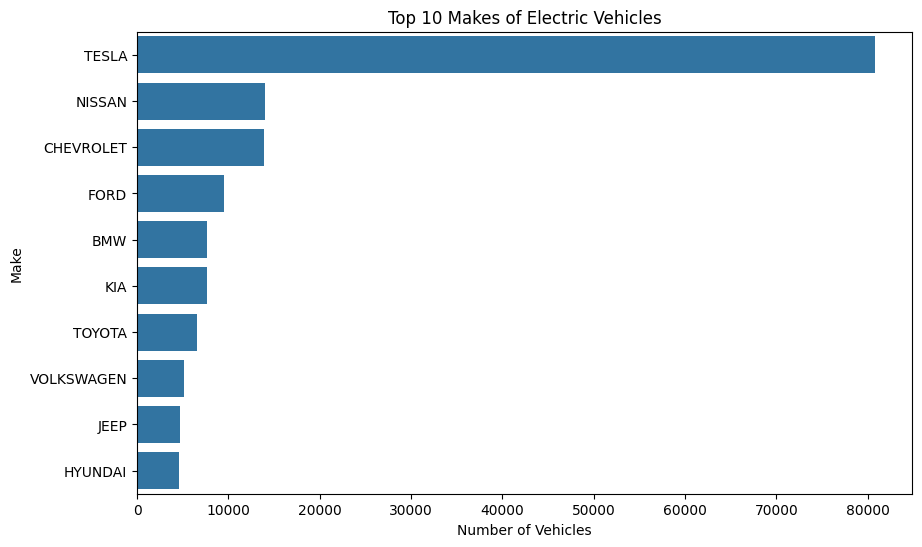

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="Make", data=grouped_data_make.head(10))
plt.title("Top 10 Makes of Electric Vehicles")
plt.xlabel("Number of Vehicles")
plt.ylabel("Make")
plt.show()

In [19]:
grouped_data_type = (
    generalized_data.groupby(["Electric Vehicle Type", "State"])
    .size()
    .reset_index(name="Count")
)
grouped_data_type = grouped_data_type.sort_values(by=["Count"], ascending=False)
grouped_data_type.head()

,Electric Vehicle Type,State,Count
3,FullElectric,West,141813
7,HybridElectric,West,39401
2,FullElectric,South,84
6,HybridElectric,South,46
1,FullElectric,Northeast,41


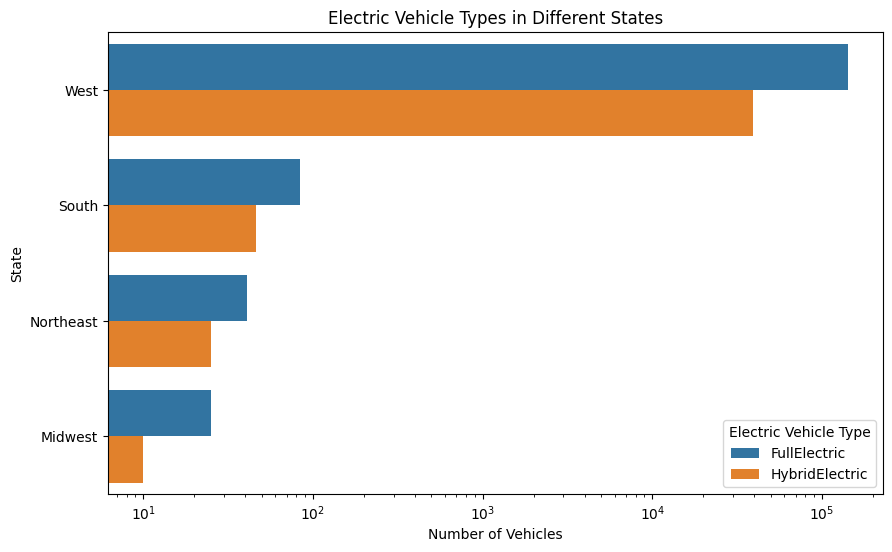

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="State", hue="Electric Vehicle Type", data=grouped_data_type)
plt.title("Electric Vehicle Types in Different States")
plt.xlabel("Number of Vehicles")
plt.ylabel("State")
plt.xscale("log")
plt.show()

In [21]:
grouped_data_range = (
    generalized_data.groupby(["Electric Range", "Base MSRP"])
    .size()
    .reset_index(name="Count")
)
grouped_data_range = grouped_data_range.sort_values(by=["Count"], ascending=False)
grouped_data_range.head()

,Electric Range,Base MSRP,Count
0,LongRange,HighEnd,89451
4,ShortRange,HighEnd,65559
2,MediumRange,HighEnd,13521
5,ShortRange,MidRange,10038
3,MediumRange,MidRange,2048


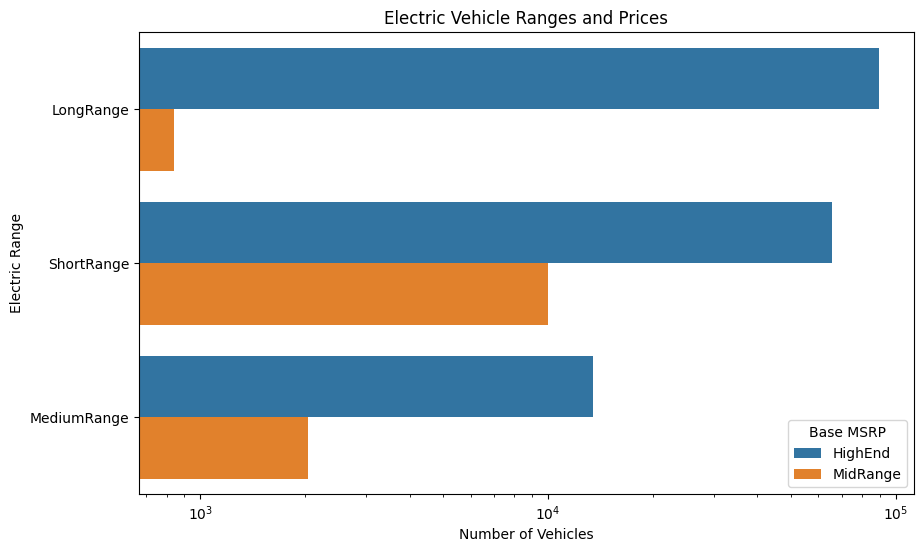

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Count", y="Electric Range", hue="Base MSRP", data=grouped_data_range)
plt.title("Electric Vehicle Ranges and Prices")
plt.xlabel("Number of Vehicles")
plt.ylabel("Electric Range")
plt.xscale("log")
plt.show()

In [23]:
grouped_data_year = (
    generalized_data.groupby(["Model Year", "Make", "Model"])
    .size()
    .reset_index(name="Count")
)
grouped_data_year = grouped_data_year.sort_values(by=["Count"], ascending=False)
grouped_data_year.head()

,Model Year,Make,Model,Count
164,2020s,TESLA,MODEL Y,37007
161,2020s,TESLA,MODEL 3,19953
52,2010s,TESLA,MODEL 3,10197
44,2010s,NISSAN,LEAF,10121
53,2010s,TESLA,MODEL S,5588


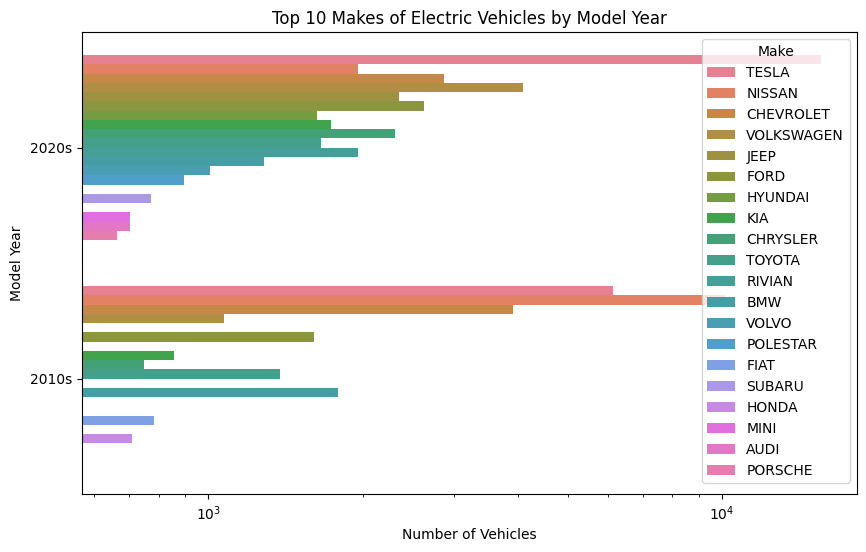

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Count",
    y="Model Year",
    hue="Make",
    data=grouped_data_year.head(50),
    errorbar=None,
)
plt.title("Top 10 Makes of Electric Vehicles by Model Year")
plt.xlabel("Number of Vehicles")
plt.xscale("log")
plt.ylabel("Model Year")
plt.show()

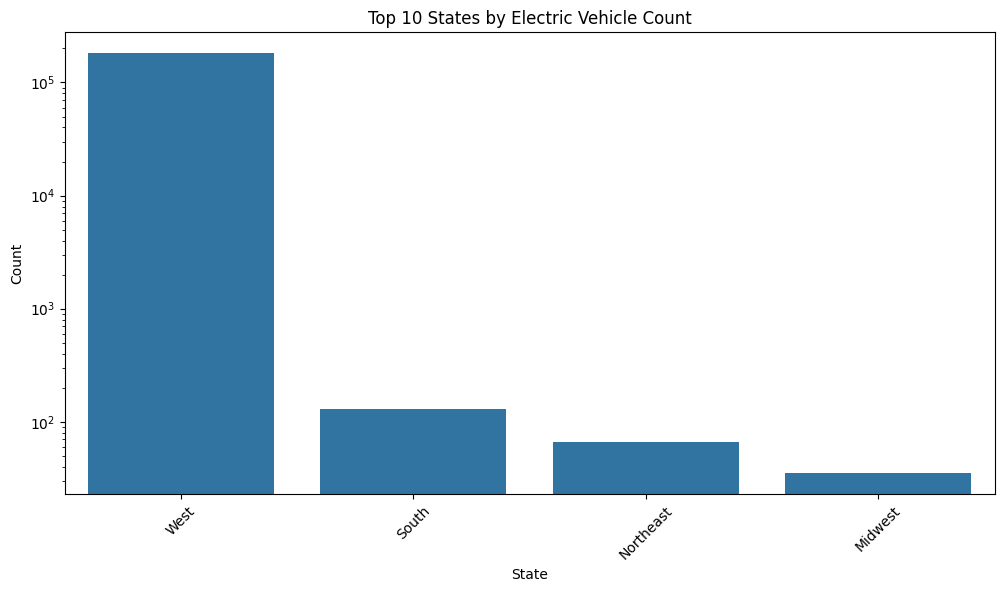

In [25]:
state_count = (
    generalized_data.groupby("State")
    .size()
    .sort_values(ascending=False)
    .reset_index(name="Count")
)
plt.figure(figsize=(12, 6))
sns.barplot(x="State", y="Count", data=state_count.head(10))
plt.title("Top 10 States by Electric Vehicle Count")
plt.xticks(rotation=45)
plt.yscale("log")
plt.show()

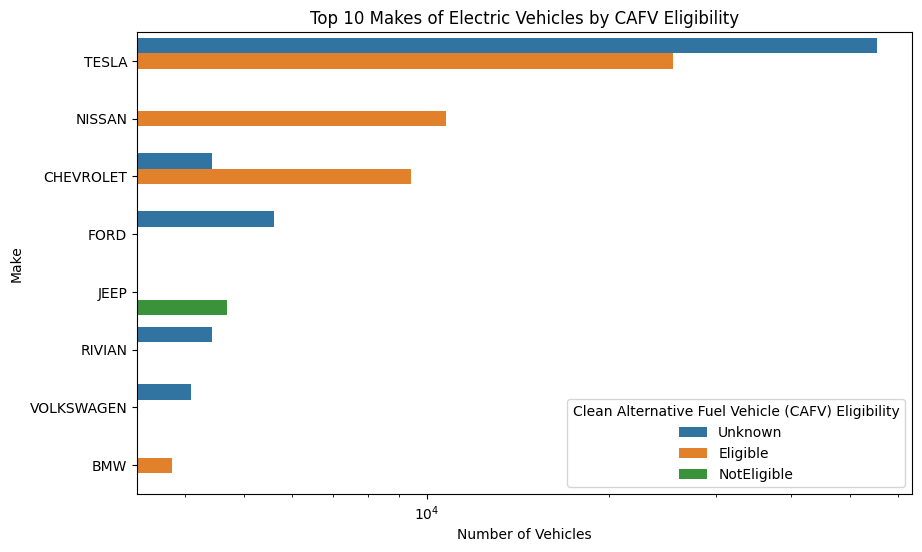

In [26]:
grouped_data_cafv = (
    generalized_data.groupby(
        ["Clean Alternative Fuel Vehicle (CAFV) Eligibility", "Make"]
    )
    .size()
    .reset_index(name="Count")
)

grouped_data_cafv = grouped_data_cafv.sort_values(by=["Count"], ascending=False)
top_10_cafv = grouped_data_cafv.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Count",
    y="Make",
    hue="Clean Alternative Fuel Vehicle (CAFV) Eligibility",
    data=top_10_cafv,
)
plt.title("Top 10 Makes of Electric Vehicles by CAFV Eligibility")
plt.xlabel("Number of Vehicles")
plt.ylabel("Make")
plt.xscale("log")
plt.show()

## Bottom-Up Cube (BUC) Algorithm

approach

In [68]:
class BUC:
    def __init__(self, inputRelation, minsup=1):
        self.inputRelation = inputRelation
        self.fields = list(inputRelation.columns)
        self.numDims = len(self.fields)
        self.minsup = minsup
        self.results = []

    def partition(self, inputRelation, d):
        # Partition based on the distinct values of dimension d
        counts = inputRelation.groupby(self.fields[d]).size().reset_index(name='Count')
        return counts

    def run_buc(self, inputRelation, dim, level=0, startingAttr=None):
        if inputRelation.shape[0] <= 1:
            return

        newTable = "temptable" + str(dim)

        for d in range(dim, self.numDims):
            curTable = inputRelation.sort_values(by=self.fields[d])

            if curTable.shape[0] <= 1:
                return

            counts = self.partition(curTable, d)
            k = 0

            for i, row in counts.iterrows():
                count = row['Count']
                if count >= self.minsup:
                    if level == 0:
                        startingAttr = d
                    strTemp = str(curTable.iloc[k][self.fields[startingAttr]])

                    for j in range(d - level + 1, d + 1):
                        strTemp += "-" + str(curTable.iloc[k][self.fields[j]])

                    self.results.append((strTemp, count))

                    subset = curTable[curTable[self.fields[d]] == curTable.iloc[k][self.fields[d]]]
                    self.run_buc(subset, d + 1, level + 1, startingAttr)
                k += count

    def get_results(self):
        return self.results

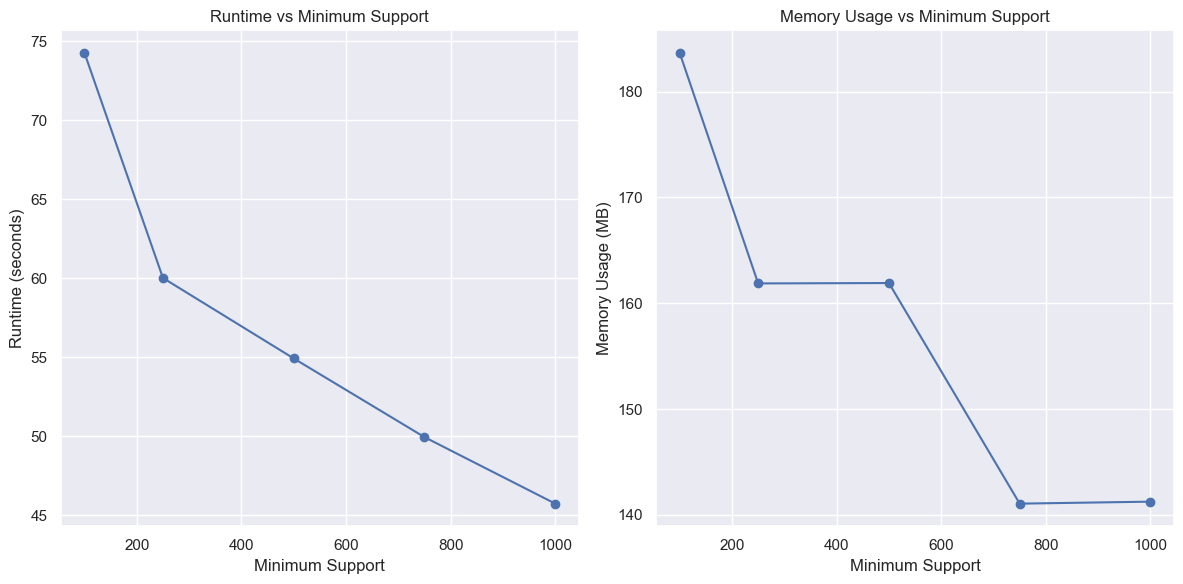

In [69]:

# Run BUC and profile runtime/memory usage
minsup_values = [100, 250, 500, 750, 1000]  # Different minimum support thresholds
runtimes = []
mem_usages = []

for minsup in minsup_values:
    start_time = time.time()

    mem_usage = memory_usage((BUC, (generalized_data,), {"minsup": minsup}), interval=0.1)
    buc = BUC(generalized_data, minsup=minsup)
    buc.run_buc(generalized_data, 0)
    
    end_time = time.time()
    
    runtimes.append(end_time - start_time)
    mem_usages.append(max(mem_usage))

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot runtime vs minsup
plt.subplot(1, 2, 1)
plt.plot(minsup_values, runtimes, marker='o')
plt.title('Runtime vs Minimum Support')
plt.xlabel('Minimum Support')
plt.ylabel('Runtime (seconds)')

# Plot memory usage vs minsup
plt.subplot(1, 2, 2)
plt.plot(minsup_values, mem_usages, marker='o')
plt.title('Memory Usage vs Minimum Support')
plt.xlabel('Minimum Support')
plt.ylabel('Memory Usage (MB)')

plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
import os
import shutil
from collections import defaultdict

class BUCOutOfMemory:
    def __init__(self, inputRelation, minsup=1, chunk_size=1000, temp_dir='temp_chunks'):
        self.inputRelation = inputRelation
        self.fields = list(inputRelation.columns)
        self.numDims = len(self.fields)
        self.minsup = minsup
        self.chunk_size = chunk_size
        self.temp_dir = temp_dir
        self.results = defaultdict(int)
        
        if not os.path.exists(self.temp_dir):
            os.makedirs(self.temp_dir)

    def partition(self, inputRelation, d):
        # Partition based on the distinct values of dimension d
        counts = inputRelation.groupby(self.fields[d]).size().reset_index(name='Count')
        return counts

    def save_chunk(self, chunk, chunk_id):
        chunk_path = os.path.join(self.temp_dir, f'chunk_{chunk_id}.csv')
        chunk.to_csv(chunk_path, index=False)
        return chunk_path

    def load_chunk(self, chunk_id):
        chunk_path = os.path.join(self.temp_dir, f'chunk_{chunk_id}.csv')
        return pd.read_csv(chunk_path)

    def run_buc_on_chunk(self, chunk_id, dim, level=0, startingAttr=None):
        curTable = self.load_chunk(chunk_id)
        
        if curTable.shape[0] <= 1:
            return

        for d in range(dim, self.numDims):
            curTable = curTable.sort_values(by=self.fields[d])

            if curTable.shape[0] <= 1:
                return

            counts = self.partition(curTable, d)
            k = 0

            for i, row in counts.iterrows():
                count = row['Count']
                if count >= self.minsup:
                    if level == 0:
                        startingAttr = d
                    strTemp = str(curTable.iloc[k][self.fields[startingAttr]])

                    for j in range(d - level + 1, d + 1):
                        strTemp += "-" + str(curTable.iloc[k][self.fields[j]])

                    # Aggregate the result
                    self.results[strTemp] += count

                    subset = curTable[curTable[self.fields[d]] == curTable.iloc[k][self.fields[d]]]
                    new_chunk_id = f"{chunk_id}_{d}_{i}"  # Properly name the new chunk id
                    self.save_chunk(subset, new_chunk_id)
                    self.run_buc_on_chunk(new_chunk_id, d + 1, level + 1, startingAttr)
                k += count

    def run_buc(self):
        # Split the data into manageable chunks
        chunk_id = 0
        for start_row in range(0, len(self.inputRelation), self.chunk_size):
            end_row = start_row + self.chunk_size
            chunk = self.inputRelation.iloc[start_row:end_row]
            chunk_path = self.save_chunk(chunk, chunk_id)
            self.run_buc_on_chunk(chunk_id, 0)
            chunk_id += 1

    def merge_results(self):
        # In this case, since we're already aggregating counts during processing,
        # the merge phase is essentially done in the run_buc_on_chunk method.
        # If partial results were stored separately, we would load and merge them here.
        pass

    def cleanup(self):
        # Remove the temporary directory to clean up the disk space
        shutil.rmtree(self.temp_dir)

    def get_results(self):
        return sorted(self.results.items(), key=lambda x: -x[1])

# Example Usage
minsup = 250
chunk_size = 20000  # Define the size of chunks to be processed in-memory

buc = BUCOutOfMemory(generalized_data, minsup=minsup, chunk_size=chunk_size)
buc.run_buc()
buc.merge_results()
results = buc.get_results()
buc.cleanup()

# Print results
for res in results:
    print(f'Pattern: {res[0]}, Count: {res[1]}')


Pattern: TESLA-HighEnd-2020s-West-Unknown, Count: 1084304
Pattern: TESLA-2020s-West-Unknown, Count: 818696
Pattern: TESLA-LongRange-HighEnd-2020s-West-Unknown, Count: 807761
Pattern: TESLA-LongRange-HighEnd-2020s-West, Count: 565655
Pattern: FullElectric-2020s-West-Unknown, Count: 536638
Pattern: TESLA-HighEnd-2020s-West, Count: 524163
Pattern: TESLA-LongRange-HighEnd-2020s, Count: 368862
Pattern: FullElectric-West-Unknown, Count: 365736
Pattern: MODEL Y-2020s-West-Unknown, Count: 346208
Pattern: MODEL Y-HighEnd-2020s-West-Unknown, Count: 346132
Pattern: FullElectric-HighEnd-2020s-West-Unknown, Count: 339994
Pattern: TESLA-West-Unknown, Count: 329666
Pattern: TESLA-FullElectric-LongRange-HighEnd-2020s-West-Unknown, Count: 320918
Pattern: TESLA-FullElectric-LongRange-HighEnd-2020s-West, Count: 294752
Pattern: FullElectric-2020s-West, Count: 263996
Pattern: FullElectric-HighEnd-2020s-West, Count: 258110
Pattern: TESLA-HighEnd-2010s-West-Eligible, Count: 248652
Pattern: TESLA-HighEnd-2020

In [15]:
import pandas as pd
import os
import shutil
from collections import defaultdict

class BUCOutOfMemory:
    def __init__(self, inputRelation, minsup=1, chunk_size=1000, temp_dir='temp_chunks'):
        self.inputRelation = inputRelation
        self.fields = list(inputRelation.columns)
        self.numDims = len(self.fields)
        self.minsup = minsup
        self.chunk_size = chunk_size
        self.temp_dir = temp_dir
        self.results = []

        if not os.path.exists(self.temp_dir):
            os.makedirs(self.temp_dir)

    def partition(self, inputRelation, d):
        # Partition based on the distinct values of dimension d
        counts = inputRelation.groupby(self.fields[d]).size().reset_index(name='Count')
        return counts

    def save_chunk(self, chunk, chunk_id):
        chunk_path = os.path.join(self.temp_dir, f'chunk_{chunk_id}.csv')
        chunk.to_csv(chunk_path, index=False)
        return chunk_path

    def load_chunk(self, chunk_id):
        chunk_path = os.path.join(self.temp_dir, f'chunk_{chunk_id}.csv')
        return pd.read_csv(chunk_path)

    def run_buc_on_chunk(self, chunk_id, dim, level=0, pattern=None):
        curTable = self.load_chunk(chunk_id)
        
        if curTable.shape[0] <= 1:
            return

        if pattern is None:
            pattern = ["*"] * self.numDims

        for d in range(dim, self.numDims):
            curTable = curTable.sort_values(by=self.fields[d])

            if curTable.shape[0] <= 1:
                return

            counts = self.partition(curTable, d)
            k = 0

            for i, row in counts.iterrows():
                count = row['Count']
                if count >= self.minsup:
                    new_pattern = pattern[:]
                    new_pattern[d] = curTable.iloc[k][self.fields[d]]
                    self.results.append(new_pattern + [count])

                    subset = curTable[curTable[self.fields[d]] == curTable.iloc[k][self.fields[d]]]
                    new_chunk_id = f"{chunk_id}_{d}_{i}"  # Properly name the new chunk id
                    self.save_chunk(subset, new_chunk_id)
                    self.run_buc_on_chunk(new_chunk_id, d + 1, level + 1, new_pattern)
                k += count

    def run_buc(self):
        # Split the data into manageable chunks
        chunk_id = 0
        for start_row in range(0, len(self.inputRelation), self.chunk_size):
            end_row = start_row + self.chunk_size
            chunk = self.inputRelation.iloc[start_row:end_row]
            self.save_chunk(chunk, chunk_id)
            self.run_buc_on_chunk(chunk_id, 0)
            chunk_id += 1

    def merge_results(self):
        # Already done during the processing phase in this implementation
        pass

    def cleanup(self):
        # Remove the temporary directory to clean up the disk space
        shutil.rmtree(self.temp_dir)

    def get_results(self):
        result_df = pd.DataFrame(self.results, columns=self.fields + ['Count'])
        return result_df

# Example Usage
minsup = 250
# chunk_size = 20000  # Define the size of chunks to be processed in-memory
chunk_sizes = [1000, 5000, 10000, 50000, 100000]  # Different chunk sizes to test
runtimes = []

for chunk_size in chunk_sizes:
    start_time = time.time()
    buc = BUCOutOfMemory(generalized_data, minsup=minsup, chunk_size=chunk_size)
    buc.run_buc()
    buc.merge_results()
    result_df = buc.get_results()
    print(result_df)
    buc.cleanup()
    end_time = time.time()
    runtimes.append(end_time - start_time)

# Display the resulting DataFrame
# result_df


        Make Model Electric Vehicle Type Electric Range Base MSRP Model Year  \
0      TESLA     *                     *              *         *          *   
1      TESLA     *          FullElectric              *         *          *   
2      TESLA     *          FullElectric      LongRange         *          *   
3      TESLA     *          FullElectric      LongRange   HighEnd          *   
4      TESLA     *          FullElectric      LongRange   HighEnd      2020s   
...      ...   ...                   ...            ...       ...        ...   
26148      *     *                     *              *   HighEnd      2020s   
26149      *     *                     *              *   HighEnd          *   
26150      *     *                     *              *         *      2020s   
26151      *     *                     *              *         *      2020s   
26152      *     *                     *              *         *          *   

      State Clean Alternative Fuel Vehi

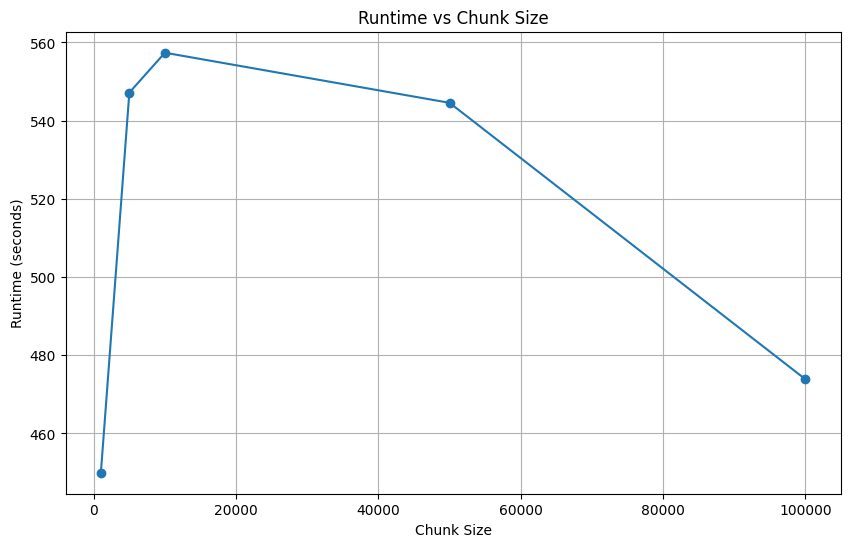

In [16]:
#plot

plt.figure(figsize=(10, 6))
plt.plot(chunk_sizes, runtimes, marker='o')
plt.title('Runtime vs Chunk Size')
plt.xlabel('Chunk Size')
plt.ylabel('Runtime (seconds)')
plt.grid(True)
plt.show()